From Bartholomew & Kwakkel (2020):

Multi-scenario many-objective robust decision making Multi-scenario MORDM (Watson and Kasprzyk, 2017) is a further refinement of MORDM. The main contribution of MORDM was the use of a MOEA for finding a set of promising candidate solutions which together capture the key trade-offs amongst competing objectives. However, this search uses a single reference scenario, and it is unlikely that solutions that are optimal in a given scenario are also optimally robust. Multi-scenario MORDM (Fig. 1(c)) addresses this by performing a search for candidate strategies for several different reference scenarios. The additional scenarios for which search is performed are selected from regions in the deep uncertainty space where candidate solutions found for the first reference scenario are failing to meet their objectives. So, one performs the four MORDM steps, and based on the insights from scenario discovery, additional scenarios are selected for which search is also performed. The goal of this is to build a more diverse set of policy alternatives which are Pareto optimal under
different scenarios. The selection of scenarios after the first MORDM iteration is a critical step in multi-scenario MORDM (Eker and Kwakkel, 2018). Watson and Kasprzyk (2017) suggest picking scenarios based on the scenario discovery results. The number of scenarios to select is left to the analyst. Clearly, if the number of scenarios for which a search is conducted increases, the chance of finding solutions that are robust during the re-evaluation also increases. However, this comes at a substantial computational cost. To assist in balancing comprehensiveness and computational cost, while making scenario selection transparent and reproducible, Eker and Kwakkel (2018) present an approach for finding the most policy relevant and maximally diverse set of scenarios. Policy relevance is defined as scenarios that lead to poor outcomes and the diversity criterion is based on Carlsen et al. (2016).

# A. Many-Objective Robust Decision Making with Multi-Scenario Search

In [1]:
# import libraries
from ema_workbench import (
    Model,
    MultiprocessingEvaluator,
    ScalarOutcome,
    IntegerParameter,
    optimize,
    Scenario, 
    save_results,
    load_results,
    MPIEvaluator,
    ema_logging
)
from ema_workbench.analysis import parcoords
from ema_workbench.em_framework.optimization import (ArchiveLogger, EpsilonProgress, rebuild_platypus_population, to_problem, Hypervolume)
from problem_formulation import get_model_for_problem_formulation
from concurrent.futures import ProcessPoolExecutor
import os
import functools
from scipy.spatial.distance import pdist, squareform
import random
from scenario_selection import find_maxdiverse_scenarios
import numpy as np
import matplotlib as mpl

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import pandas as pd
import itertools

### A.1. Problem formulation

In [2]:
# if __name__ == "__main__":
#     ema_logging.log_to_stderr(ema_logging.INFO)
# 
#     model, steps = get_model_for_problem_formulation(3)

### A.2. Scenario selection

It is desirable to search for candidate solutions under a variety of scenarios, so that robustness of potential solutions is increased (Eker and Kwakkel, 2018).

In this study, our purpose for scenario selection is to find scenarios that potentially lead to solutions that are more robust when
the search phase of MORDM is conducted for each of these scenarios. Therefore, among the possible scenario selection criteria
listed above, we consider policy relevance and diversity as the
relevant ones. Policy-relevance is a problem-specific concept that
should reflect the decision-making concerns and preferences. In
this study, we choose to define policy-relevance with respect to
undesirable scenario conditions specified by the median values of
the scenario space. Dividing the scenario space at the median
values focuses the diversity analysis on a smaller number of policy-relevant scenarios regardless of their distribution. However, we do
not propose this as a general way to define policy relevance. For the
diversity criterion, we propose to use the specific diversity
maximization method introduced by Carlsen et al. (2016b).

Following Eker and Kwakkel (2018), scenario selection is conducted in three steps, namely
- 1. Scenario generation;
- 2. Filtering of policy-relevant scenarios;
- 3. Selecting maximally diverse scenarios.

#### A.2.1. Scenario generation and A.2.2. Filtering of policy-relevant scenarios

In this step, N scenarios will be generated using randomly sampled values of deep uncertainties and decision levers (Eker and Kwakkel, 2018) .

Due to computational restrictions, only a limited amount of scenarios is used. In this step, scenarios are filtered based on their policy relevance.

In the next step, scenarios will be selected using an indicator for scenario diversity.


In [3]:
scenarios, outcomes = load_results("./results/scenario_selection.tar.gz")

In [4]:
scenarios

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model
0,105,158.533238,10.0,0.537359,315.145762,1.0,0.343249,290.983221,1.0,0.213538,...,0,0,0,0,0,0,0,2,Policy 0,dikesnet
1,122,189.698330,1.0,0.682612,299.782340,1.0,0.708662,176.717249,10.0,0.335554,...,0,0,0,0,0,0,0,33,Policy 0,dikesnet
2,8,124.406106,10.0,0.564305,188.281947,1.5,0.363772,258.363480,10.0,0.238341,...,0,0,0,0,0,0,0,56,Policy 0,dikesnet
3,7,92.494983,10.0,0.695807,141.911870,10.0,0.761783,113.549535,10.0,0.034505,...,0,0,0,0,0,0,0,70,Policy 0,dikesnet
4,93,40.537874,1.5,0.712848,49.618879,1.5,0.547637,205.325470,1.0,0.425226,...,0,0,0,0,0,0,0,117,Policy 0,dikesnet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,11,122.316720,1.0,0.572786,114.275576,1.5,0.569826,139.651981,1.0,0.072716,...,0,0,0,0,0,0,0,4899,Policy 0,dikesnet
276,101,281.165784,1.0,0.693964,42.142980,10.0,0.604134,141.749554,10.0,0.238004,...,0,0,0,0,0,0,0,4924,Policy 0,dikesnet
277,33,43.823637,1.0,0.643488,303.542361,1.5,0.779226,299.602868,10.0,0.028695,...,0,0,0,0,0,0,0,4934,Policy 0,dikesnet
278,114,80.309914,1.0,0.542835,179.860698,1.5,0.340880,92.264076,1.0,0.358026,...,0,0,0,0,0,0,0,4950,Policy 0,dikesnet


#### A.2.3. Selecting maximally diverse scenarios

It is desirable to select maximally diverse scenarios, so that ... ? In this step, maximally diverse scenarios will be selected following the approach of Carlsen et al. (2016).

#### Normalizing all outcomes

In [5]:
experiments_of_interest = scenarios['scenario']
outcomes_df = pd.DataFrame({k:v[experiments_of_interest] for k,v in outcomes.items()})
# normalize outcomes on unit interval to ensure equal weighting of outcomes
x = outcomes_df.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
normalized_outcomes = pd.DataFrame(x_scaled, columns=outcomes_df.columns)

In [6]:
normalized_outcomes.describe()

,A.1 Total Costs,A.1_Expected Number of Deaths,A.2 Total Costs,A.2_Expected Number of Deaths,A.3 Total Costs,A.3_Expected Number of Deaths,A.4 Total Costs,A.4_Expected Number of Deaths,A.5 Total Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs
count,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000,280.0,280.0
mean,0.289275,0.396852,0.212362,0.242325,0.480620,0.672651,0.107348,0.124819,0.068383,0.078143,0.0,0.0
std,0.207799,0.284415,0.197081,0.217484,0.242927,0.312480,0.226668,0.257644,0.201234,0.227594,0.0,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
25%,0.128633,0.167743,0.064113,0.071439,0.268359,0.388498,0.000000,0.000000,0.000000,0.000000,0.0,0.0
50%,0.230862,0.332648,0.135318,0.133737,0.523392,0.741661,0.000000,0.000000,0.000000,0.000000,0.0,0.0
75%,0.393446,0.576426,0.310517,0.335590,0.691118,0.974567,0.053287,0.065566,0.000000,0.000000,0.0,0.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0


#### Creating all possible permutations of 4 scenarios

In [7]:
# n_scen = experiments_of_interest.shape[0]
# print("Number of scenarios generated:", n_scen)
# indices = range(n_scen)
# set_size = 4
# combinations = itertools.combinations(indices, set_size)
# combinations = list(combinations)
# print("Number of combinations generated:", len(combinations))

#### Calculating diversity of each of the combinations

In [8]:
# #The following code snippet is adopted from assignment 10 model answers (Kwakkel, 2024)
# 
# # calculate the pairwise distances between the normalized outcomes
# distances = squareform(pdist(normalized_outcomes.values))
# 
# cores = os.cpu_count()
# partial_function = functools.partial(find_maxdiverse_scenarios, distances)

In [9]:
# sampled_combinations = random.sample(combinations, 50000)

In [10]:
# # setup the pool of workers and split the calculations over the set of cores
# with ProcessPoolExecutor(max_workers=cores) as executor:
#     worker_data = np.array_split(sampled_combinations, cores)
#     results = [e for e in executor.map(partial_function, worker_data)]
#     results = list(itertools.chain.from_iterable(results))

#### Check most diverse results

In [11]:
# # #The following code snippet is adopted from assignment 10 model answers (Kwakkel, 2024)
# #
# results.sort(key=lambda entry:entry[0], reverse=True)
# most_diverse = results[0]
# most_diverse

Output is: ([1.699086703509649], array([ 67, 182, 257, 264]))

#### Create scenarios using most diverse scenarios

In [12]:
scenario_inputs = [i for i in scenarios.keys()]

In [13]:
scenario_inputs = scenario_inputs[0:19]

In [14]:
print(scenario_inputs)

['A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_Brate', 'A.1_pfail', 'A.2_Bmax', 'A.2_Brate', 'A.2_pfail', 'A.3_Bmax', 'A.3_Brate', 'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_pfail', 'A.5_Bmax', 'A.5_Brate', 'A.5_pfail', 'discount rate 0', 'discount rate 1', 'discount rate 2']


In [15]:
#The following code snippet is adopted from assignment 10 model answers (Kwakkel, 2024)

# select columns which are uncertainties
selected = scenarios[scenario_inputs]
# most_diverse = ([1.699086703509649], np.array([ 67, 182, 257, 264])) # follows from analysis above
indices = [67, 182, 257, 264]
# select only these four scenarios
selected = selected.loc[indices]
# define EMA scenario
scenarios = [Scenario(f"{index}", **row) for index, row in selected.iterrows()]
# print scenarios
for scenario in scenarios:
    print(scenario)
    print("\n")

Scenario({'A.0_ID flood wave shape': 44.0, 'A.1_Bmax': 286.64599121879684, 'A.1_Brate': 10.0, 'A.1_pfail': 0.707203279180436, 'A.2_Bmax': 70.7535283550602, 'A.2_Brate': 10.0, 'A.2_pfail': 0.1821768730444873, 'A.3_Bmax': 71.83446711156625, 'A.3_Brate': 10.0, 'A.3_pfail': 0.4088389187038367, 'A.4_Bmax': 232.45895828113493, 'A.4_Brate': 10.0, 'A.4_pfail': 0.0250796789063121, 'A.5_Bmax': 309.2326438335386, 'A.5_Brate': 1.5, 'A.5_pfail': 0.1372716851642172, 'discount rate 0': 1.5, 'discount rate 1': 3.5, 'discount rate 2': 3.5})


Scenario({'A.0_ID flood wave shape': 45.0, 'A.1_Bmax': 39.355371708328974, 'A.1_Brate': 1.5, 'A.1_pfail': 0.5550709615297844, 'A.2_Bmax': 168.33572498519675, 'A.2_Brate': 10.0, 'A.2_pfail': 0.6160894780908688, 'A.3_Bmax': 204.51182823914576, 'A.3_Brate': 1.5, 'A.3_pfail': 0.3190998245752335, 'A.4_Bmax': 188.4745656476624, 'A.4_Brate': 1.5, 'A.4_pfail': 0.4240709667157523, 'A.5_Bmax': 334.2027988375561, 'A.5_Brate': 1.5, 'A.5_pfail': 0.03716758608412, 'discount rat

In [16]:
model, steps = get_model_for_problem_formulation(3)

reference_values = {
    "Bmax": 175,
    "Brate": 1.5,
    "pfail": 0.5,
    "discount rate 0": 3.5,
    "discount rate 1": 3.5,
    "discount rate 2": 3.5,
    "ID flood wave shape": 4,
}
scen1 = {}

for key in model.uncertainties:
    name_split = key.name.split("_")

    if len(name_split) == 1:
        scen1.update({key.name: reference_values[key.name]})

    else:
        scen1.update({key.name: reference_values[name_split[1]]})

# define reference scenario
ref_scenario = Scenario("reference", **scen1)
# add reference scenario to scenarios
scenarios.append(ref_scenario)

In [17]:
for i in scenarios: 
    print(i)
    print('\n')

Scenario({'A.0_ID flood wave shape': 44.0, 'A.1_Bmax': 286.64599121879684, 'A.1_Brate': 10.0, 'A.1_pfail': 0.707203279180436, 'A.2_Bmax': 70.7535283550602, 'A.2_Brate': 10.0, 'A.2_pfail': 0.1821768730444873, 'A.3_Bmax': 71.83446711156625, 'A.3_Brate': 10.0, 'A.3_pfail': 0.4088389187038367, 'A.4_Bmax': 232.45895828113493, 'A.4_Brate': 10.0, 'A.4_pfail': 0.0250796789063121, 'A.5_Bmax': 309.2326438335386, 'A.5_Brate': 1.5, 'A.5_pfail': 0.1372716851642172, 'discount rate 0': 1.5, 'discount rate 1': 3.5, 'discount rate 2': 3.5})


Scenario({'A.0_ID flood wave shape': 45.0, 'A.1_Bmax': 39.355371708328974, 'A.1_Brate': 1.5, 'A.1_pfail': 0.5550709615297844, 'A.2_Bmax': 168.33572498519675, 'A.2_Brate': 10.0, 'A.2_pfail': 0.6160894780908688, 'A.3_Bmax': 204.51182823914576, 'A.3_Brate': 1.5, 'A.3_pfail': 0.3190998245752335, 'A.4_Bmax': 188.4745656476624, 'A.4_Brate': 1.5, 'A.4_pfail': 0.4240709667157523, 'A.5_Bmax': 334.2027988375561, 'A.5_Brate': 1.5, 'A.5_pfail': 0.03716758608412, 'discount rat

### A.3. Generating candidate solutions

Following the scenario selection of the previous step, in this step the Multi-Objective Evolutionary Algorithm (MOEA) epsilon-NSGAII algorithm (Kollat and Reed, 2006)  is used to generate candidate solutions, following the approach of Eker and Kwakkel (2018). + explain how epsilon-NSGAII algorithm works + explain benefits of epsilon-NSGAII algorithm for this case

#### Creating a function to optimize under a certain scenario

In [ ]:
if __name__ == "__main__":
    ema_logging.log_to_stderr(ema_logging.INFO)
    # define the model and steps
    model, steps = get_model_for_problem_formulation(3)

    def optimize(model, scenario, nfe, epsilons, seed_nr):
        results = []
        convergences = []
        with MultiprocessingEvaluator(model) as evaluator:
            for i in range(seed_nr):
                convergence_metrics = [ArchiveLogger(
                    "./results/",
                    [l.name for l in model.levers],
                    [o.name for o in model.outcomes],
                    base_filename=f"optimization_3_{scenario.name}_seed_{i}.tar.gz"),
                    EpsilonProgress(),
                ]

                result, convergence = evaluator.optimize(nfe=nfe, searchover='levers',
                                                         convergence=convergence_metrics,
                                                         epsilons=epsilons,
                                                         reference=scenario)
                results.append(result)
                convergences.append(convergence)

        return results, convergences

    optimizations = []
    fig, ax = plt.subplots(ncols=1)
    legend_items = []
    colors = sns.color_palette()
    for scenario in scenarios:
        if scenario.name == 'reference':
            color = colors[0]
            legend_items.append((mpl.lines.Line2D([0,0], [1,1], c=color), scenario.name))
            # epsilons = [1e5, ] * len(model.outcomes)
            epsilons = [1e4, 0.01, 1e4, 0.01, 1e4, 0.01, 1e4, 0.01, 1e4, 0.01, 1e4, 1e4]
            optimizer = optimize(model, scenario, 100000, epsilons, 3)
            optimizations.append(optimizer)
            convergences = optimizer[1]
            for convergence in convergences:
                ax.plot(convergence.nfe, convergence.epsilon_progress, c=color)

    artists, labels = zip(*legend_items)
    fig.legend(artists, labels, bbox_to_anchor=(1.15, 0.9))
    ax.set_xlabel("Number of functional evaluations")
    ax.set_ylabel(r"$\epsilon$ progress")
    plt.title(f"Convergence of epsilon for reference scenario")
    plt.savefig(f'./results/optimization_3_{scenario.name}_convergence.png', bbox_inches='tight')
    plt.show()

# Convergence

In [11]:
def show_convergence(seed_nr=3, optimizer='opt150'): 
    """
    This function visualises the epsilon progress over the number of functional evaluations, 
    evaluating the convergence of the epsilon progress for both scenarios and seeds.
    """
    # figure settings
    fig, ax = plt.subplots(ncols=1)
    legend_items = []
    colors = sns.color_palette()
    scenario_nr = 0
    scenarios = ["reference", "67", "182", "257", "264"]
    # for each scenario
    for scenario in scenarios: 
        # one color per scenario
        color = colors[scenario_nr]
        # index scenario number added by 1
        scenario_nr += 1
        # add scenario to legend
        legend_items.append((mpl.lines.Line2D([0,0], [1,1], c=color), scenario))
        # for each seed
        for seed in range(seed_nr):
            # import convergence metrics
            convergence_metrics = pd.read_csv(f"./results/{optimizer}/optimization_3_{scenario}_seed_{seed}_convergence.csv")
            # add to figure
            ax.plot(convergence_metrics.nfe, convergence_metrics.epsilon_progress, c=color)
    # display figure    
    artists, labels = zip(*legend_items)
    fig.legend(artists, labels, bbox_to_anchor=(1.15, 0.9))
    ax.set_xlabel("Number of functional evaluations")
    ax.set_ylabel(r"$\epsilon$ progress")
    plt.title(f"Convergence of epsilon")
    plt.savefig(f'./images/opt/opt200_pf3_convergence.png', bbox_inches='tight')
    plt.show()

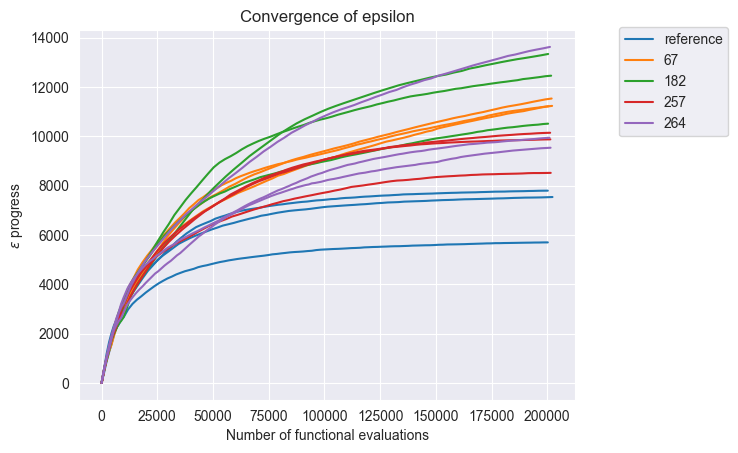

In [12]:
show_convergence(3, 'opt200')

## Analysis

In [ ]:
def analyse_solutions(optimizer='opt150', scenario='reference'): 
    """
    This function analyses the solutions generated by the optimization. 
    """
    all_archives = []
    for seed in range(seed_nr):
         # import data through archive logger
        archive = ArchiveLogger.load_archives(f"./results/{optimizer}/optimization_3_{scenario}_seed_{i}.tar.gz")  
        archive = archive[max(archive.keys())]
        archive = archive.iloc[:, 1:(len(archive.columns))]
        all_archives.append(archive)
    
        outcomes = archive.loc[:, ['A.1 Total Costs', 'A.1_Expected Number of Deaths', 'A.2 Total Costs', 'A.2_Expected Number of Deaths', 'A.3 Total Costs', 'A.3_Expected Number of Deaths','RfR Total Costs', 'Expected Evacuation Costs']]
        
        limits = parcoords.get_limits(data)

        limits.loc[0, ['A.1_Expected Number of Deaths','A.2_Expected Number of Deaths','A.3_Expected Number of Deaths',]] = 1
        limits.loc[0, 'max_P'] = 6 # max over results based on quick inspection not shown here
        limits.loc[0, 'utility'] = 1 # max over results based on quick inspection not shown here
        limits.loc[1, :] = 0
        
        axes = parcoords.ParallelAxes(limits)
        
        for i, (result, color) in enumerate(zip(all_archives, sns.color_palette())):
            outcomes = result.loc[:, ['A.1 Total Costs', 'A.1_Expected Number of Deaths', 'A.2 Total Costs', 'A.2_Expected Number of Deaths', 'A.3 Total Costs', 'A.3_Expected Number of Deaths','RfR Total Costs', 'Expected Evacuation Costs']]
            axes.plot(outcomes, label='results {}'.format(i))
            
        axes.legend()
        plt.show()

#### Reference

#### Scenario 1

#### Scenario 2

#### Scenario 3

#### Scenario 4

#### Combining the pareto set of solutions found for each scenario

#### (If you have a very large number of policies, you can choose to down sample your policies in some reasoned way (e.g., picking min and max on each objective, slicing across the pareto front with a particular step size). As a rule of thumb, try to limit the set of policies to at most 50.)

In [ ]:
# from ema_workbench import Policy
#
# policies = []
# for i, (result, _) in enumerate(results):
#     result = result.iloc[:, 0:5]
#     for j, row in result.iterrows():
#         policy = Policy(f'scenario {i} option {j}', **row.to_dict())
#         policies.append(policy)

#### Re-evaluate under deep uncertainty
Re-evaluate the combined set of solutions over 1000 scenarios sampled using LHS

In [ ]:
# with MultiprocessingEvaluator(model) as evaluator:
#     reeevaluation_results = evaluator.perform_experiments(1000, policies=policies)

### A.4. Tradeoff analysis

In [ ]:
# experiments, outcomes = reeevaluation_results
#....

**Signal-to-Noise**\
To quantify the robustness we can use multiple robustness metrices. The first one that we use is the **signal-to-noise ratio**. This is the mean of a dataset divided by the standard deviation. If we want to minimize the outcomes, a low mean and a low standard deviation is preferred.

In [52]:
def signal_to_noise(data, direction):
    "Calculate the signal-to-noise ratio of a dataset with outcome directions (minimize or maximize)"
    mean = np.mean(data)
    std = np.std(data) 
    
    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std 

In [53]:
# Empty dictionary to collect the ratio scores of every policy:
overall_scores = {}

# Loop over all policies and outcomes respectively:
for policy in np.unique(experiments['policy']):
    scores = {}
    
    logical = experiments['policy']==policy
    
    for outcome in model.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
    
# Create dataframe for visualisation purposes:
scores = pd.DataFrame.from_dict(overall_scores).T
scores

NameError: name 'experiments' is not defined

In [ ]:
# Visualise tradeoffs on a parallel plot:
from ema_workbench.analysis import parcoords

data = scores
limits = parcoords.get_limits(data)
limits.loc[0, ['A.1 Total Costs', 'A.1_Expected Number of Deaths', 'A.2 Total Costs', 'A.2_Expected Number of Deaths', 'A.3 Total Costs', 'A.3_Expected Number of Deaths','RfR Total Costs', 'Expected Evacuation Costs']] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
paraxes.invert_axis('A.1 Total Costs')
plt.show()

**Minimax regret**\
Another robustness metric that we use for our analysis is the **minimax regret** metric. This metric computes the regret for each option, then takes the ones with the maximum regret (worst-case), and then chooses the options that minimize this maximum regret. We define regret as the difference between the performance of a policy in a scenario and the performance of the best possible result in that scenario or the reference policy. The province of Gelderland is in favour of policy options with low maximum regret values, because the province is responsible for the safety of her region and pays the policies with government money. So, the province has a high level of risk aversion and therefore this robustness metric is suitable for our analysis.

Source: https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1002/2017EF000649

In [ ]:
# Empty dictionaries to get the overall and maximum regret:
overall_regret = {}
max_regret = {}

# Loop over all policies and outcomes respectively:
for outcome in model.outcomes:
    policy_column = experiments['policy']
    
    # Create DataFrame to store the outcome, name of the policy and scenario:
    data = pd.DataFrame({outcome.name: outcomes[outcome.name], 
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})
    
    # Organise the data:
    data = data.pivot(index='scenario', columns='policy')
    
    # Flatten the hierarchical index from pivoting
    data.columns = data.columns.get_level_values(1)
    
    # Take the absolute difference of the maximum across the row and the actual values in the row
    outcome_regret = (data.max(axis=1).values[:, np.newaxis] - data).abs()
    
    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()

# Visualise results in a heatmap:
max_regret = pd.DataFrame(max_regret)
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
plt.show()

In [ ]:
# Visualise tradeoffs on a parallel plot:
from ema_workbench.analysis import parcoords

colors = sns.color_palette()

data = max_regret
limits = parcoords.get_limits(data)
limits.loc[0, ['A.1 Total Costs', 'A.1_Expected Number of Deaths', 'A.2 Total Costs', 'A.2_Expected Number of Deaths', 'A.3 Total Costs', 'A.3_Expected Number of Deaths','RfR Total Costs', 'Expected Evacuation Costs']] = 0

paraxes = parcoords.ParallelAxes(limits)
for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
paraxes.legend()
plt.show()